In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from keras import models
from keras import layers
from keras import optimizers
from keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input, decode_predictions

from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.models import load_model

from IPython.display import Image
from keras.preprocessing import image

In [3]:
# load model
model = load_model('/home/newall/MSDS/MSDSCapstone/MobileNetV2_16_6_model_320x320_v2.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_320 (Model) (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [3]:
# -----------------------------LOAD IN OUR DATA---------------------------------- #
VALID = 'CheXpert-v1.0-small/valid.csv'

# generate validation set
valid = pd.read_csv(VALID, dtype=str)

### Convert sequential API model to Functional API model

Currently there is a defect with the Keras sequential model when trying to calculate the gradient of the final convolutional layer w.r.t the output of the positive class.

In [14]:
## need to move the weight from sequential API into functional API
#get mobilenet portion weights
trained_mobile_weights = model.get_layer('mobilenetv2_1.00_320').get_weights()

In [17]:
from keras.applications.mobilenet_v2 import MobileNetV2
#now lets build the functional API model and set weights from trained model

#get the model base
conv_base = MobileNetV2(weights=None, include_top=False, input_shape=(320, 320, 3))
#change model weights
conv_base.set_weights(trained_mobile_weights)

x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
predictions = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs=conv_base.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 321, 321, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 160, 160, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 160, 160, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [92]:
output = model.output

Once the the model is set up using the functional API we should be able to plot the grad-cam for that model

In [17]:
def poolGradients(model, layer):
    # function for calculating the pooled gradients of the final conv_layer w.r.t the class we want to predict
    # in this case our model only outputs a prediction for the positive case
    # function input
    #     model: functional API model
    #     layer: final output layer of the CNN
    
    output = model.output[:, 0]

    #get the last convolutional layer
    last_conv_layer = model.get_layer(layer)

    #calculate the gradient of each channel from the conv layer with respect to our postive class prediction
    grads = K.gradients(output, last_conv_layer.output)[0]

    #global pooling of the gradient
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    return last_conv_layer, pooled_grads

In [28]:

def generateCAM(img_path, last_conv_layer, pooled_grads, out_folder = 'GradCAMs/', size = (320, 320)):
    # function for plotting the activation map 
    # 
    # function input
    #     img_path: image you want to input for apply a heat map too
    #     out_folder: folder to write the superimposed CAM image too
    #     last_conv_layer: that conv layer of the network determined from pool gradients
    #     pooled_grads: global average pooled gradient of the final layer w.r.t the positive class
    
    #create the output cams:
    new = img_path.split("/")

    out_path = out_folder + "_".join(new[2:])
    
    #convert image to target size
    img = image.load_img(img_path, target_size=size)

    #convert to array
    x = image.img_to_array(img)

    #create batch size of 1
    x = np.expand_dims(x, axis=0)

    #normalize RGB range
    x = preprocess_input(x)
    
    #iterated over input images with pooled grad to get maximized activations
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    #run iterators
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    #get the output
    for i in range(pooled_grads.shape[0]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    #generate activation map and run through ReLu Activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    #superimpase on original image and store plot
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite(out_path, superimposed_img)
    
    Image(filename=out_path)
    return out_path

In [74]:
last_conv_layer, pooled_grads = poolGradients(model, 'out_relu')

In [98]:
input_image = '/home/newall/Downloads/loculated-pleural-effusion-1.jpg'
out_image = generateCAM(input_image)

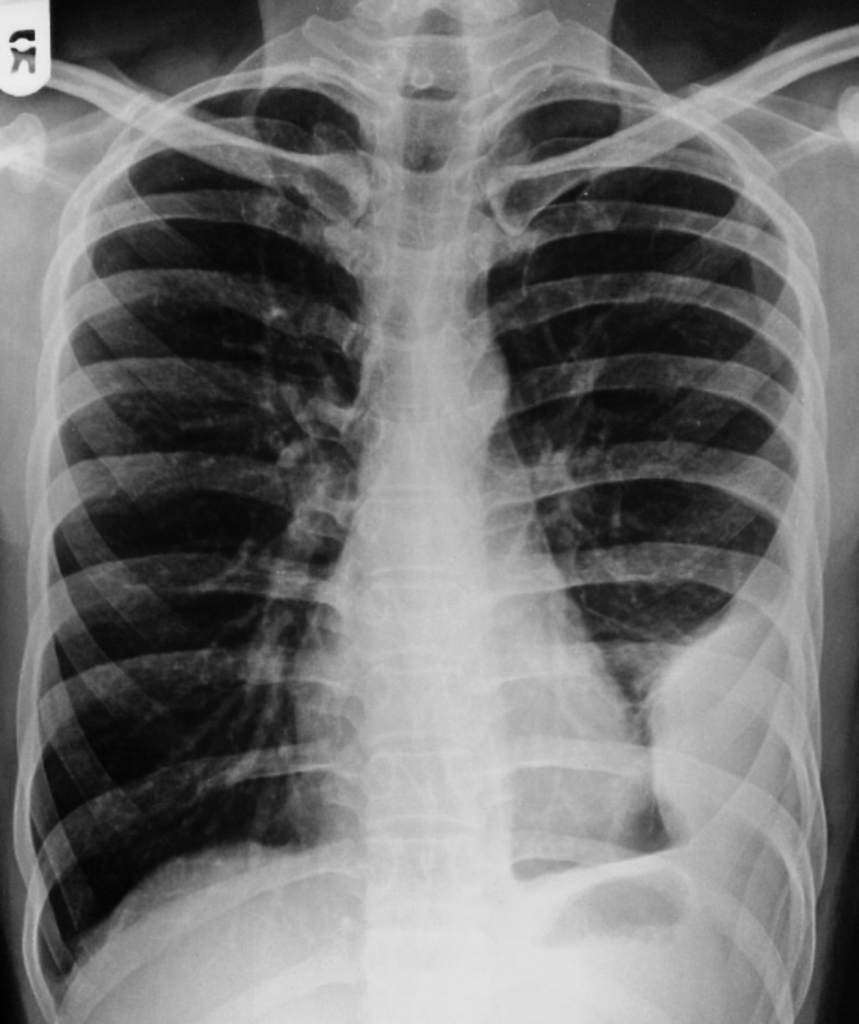

In [99]:
Image(filename=input_image)

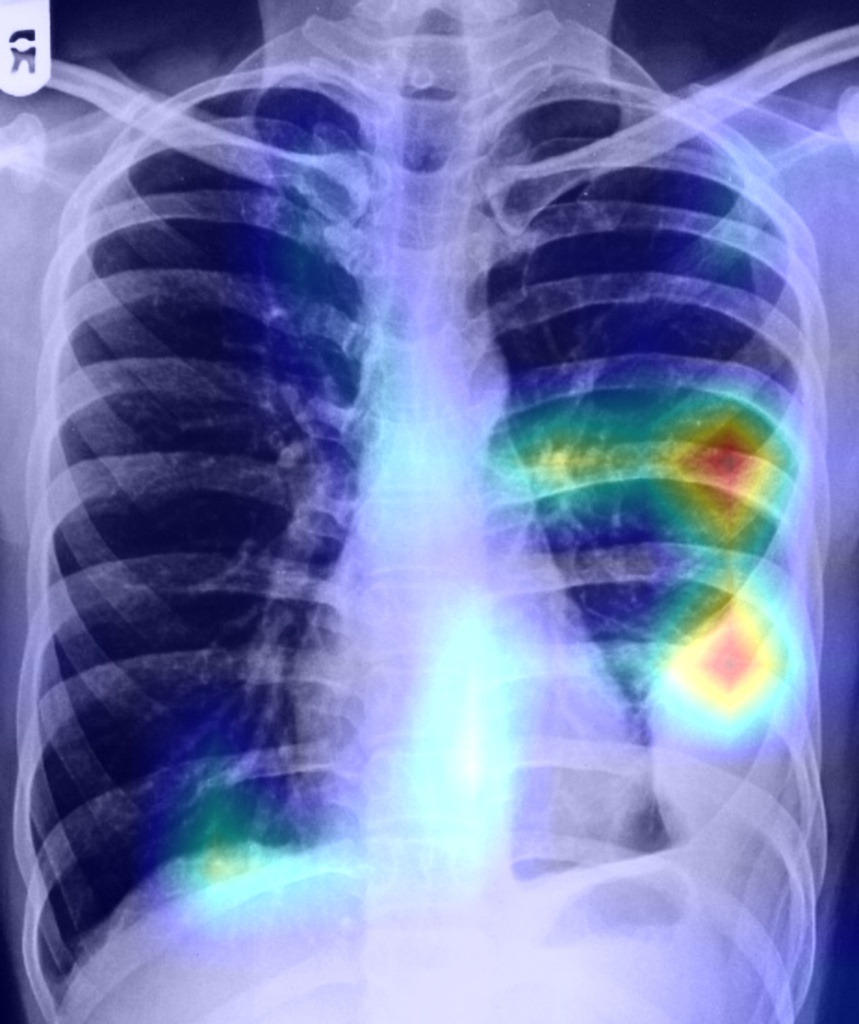

In [100]:
Image(filename=out_image)

Let generate a Class activation map for every x-ray with Pleural effusion and write to output folder

In [83]:
effusion = valid[valid['Pleural Effusion'] == '1.0']
effusion['Path'][1:5]

10    CheXpert-v1.0-small/valid/patient64548/study1/...
15    CheXpert-v1.0-small/valid/patient64552/study1/...
41    CheXpert-v1.0-small/valid/patient64571/study1/...
48    CheXpert-v1.0-small/valid/patient64577/study1/...
Name: Path, dtype: object

In [84]:
for path in effusion['Path']:
    generateCAM(path)

### Appendix Results using DenseNet121

In [4]:
from keras.applications.densenet import DenseNet121 as BASE
WEIGHTS = 'DenseNet121_16_6_weights_lr_reduce_from32.hdf5'

conv_base = BASE(include_top=True,
                input_shape=(224,224,3),
                pooling=max)

conv_base.layers.pop()
# print(conv_base.summary())

# conv_base.trainable = True
# for layer in conv_base.layers:
#     layer.trainable = True

model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(1, activation='sigmoid'))

if WEIGHTS:
    model.load_weights(WEIGHTS)

model.compile(loss='binary_crossentropy', optimizer= optimizers.Adam(), metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1000)              7037504   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1001      
Total params: 7,038,505
Trainable params: 6,954,857
Non-trainable params: 83,648
_________________________________________________________________
None


In [5]:
## need to move the weight from sequential API into functional API
#get mobilenet portion weights
trained_densenet_weights = model.get_layer('densenet121').get_weights()

In [11]:
from keras.applications.densenet import DenseNet121

#get the model base
conv_base = DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3))
#change model weights
conv_base.set_weights(trained_densenet_weights)

x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
predictions = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs=conv_base.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [27]:
last_conv_layer, pooled_grads = poolGradients(model, 'relu')
print(last_conv_layer)
print(pooled_grads.shape)

(1024,)
